In [12]:
#!/usr/bin/env python
# coding: utf-8

from utils import *
"""
######################################################################

1. add metric "siameseEucDist" - Done
2. Do data processing: siamese and classification data togther for multitasking - under procsess
3. Modify the trainer function


######################################################################
"""
# import torch
# from torchvision.datasets import FashionMNIST
# from torchvision import transforms

# mean, std = 0.28604059698879553, 0.35302424451492237
# batch_size = 256

# train_dataset = FashionMNIST('../data/FashionMNIST', train=True, download=True,
                             # transform=transforms.Compose([
                                 # transforms.ToTensor(),
                                 # transforms.Normalize((mean,), (std,))
                             # ]))
# test_dataset = FashionMNIST('../data/FashionMNIST', train=False, download=True,
                            # transform=transforms.Compose([
                                # transforms.ToTensor(),
                                # transforms.Normalize((mean,), (std,))
                            # ]))

# cuda = torch.cuda.is_available()
# kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# n_classes = 10

import torch
from torchvision.datasets import MNIST
from torchvision import transforms

mean, std = 0.1307, 0.3081

train_dataset = MNIST('../data/MNIST', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))
                             ]))
test_dataset = MNIST('../data/MNIST', train=False, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((mean,), (std,))
                            ]))
n_classes = 10


# ## Common setup

# In[3]:


import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from metrics import *
from trainer import fit, fit_siam
import numpy as np
cuda = torch.cuda.is_available()

# get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib
import matplotlib.pyplot as plt

import os
from utils import *
import utils
import sys

# gpu, seed_offset, MVLW = int(sys.argv[1]), int(sys.argv[2]), int(sys.argv[3])
gpu, seed_offset, MVLW = 3, 50, 0

os.environ["CUDA_VISIBLE_DEVICES"] = "1,2,3,4"



mnist_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mnist_classes)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda(gpu)
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels



# Set up data loaders
from datasets import SiameseMNIST, SiameseMNIST_MT

## Step 1
# siamese_train_dataset = SiameseMNIST(train_dataset) # Returns pairs of images and target same/different
# siamese_test_dataset = SiameseMNIST(test_dataset)
# batch_size = 128
# kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
# siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
# siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Step 1 - Multi-task data


# Set up the network and training parameters
from networks import EmbeddingNet, SiameseNet, SiameseNet_ClassNet
from losses import ContrastiveLoss
from losses import ContrastiveLoss_mod, CrossEntropy
# torch.manual_seed(0)
# np.random.seed(0)
log_interval = 5

siamese_MT_train_dataset = SiameseMNIST_MT(train_dataset, seed=0) # Returns pairs of images and target same/different
siamese_MT_test_dataset = SiameseMNIST_MT(test_dataset, seed=0)
interval = 0.025
write_list = []
mw_list = []
# For reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

metric_classes=[SimpleSiamDistAcc, AccumulatedAccuracyMetric_mod]

margin = 1.0

if MVLW: 
    init_mix_weight = 0.5
    n_epochs = 20
    start, interval, end = 0, 1, 1
    seedmax = 1
    log_tag = "auto"
else:
    # start, interval, end = 0, interval, 1.0 + interval
    MW = 0.85
    start, interval, end = MW, 0.25, MW + interval
    seedmax = 1
    n_epochs = 20
    log_tag = "gridsearch"



creating pairs...


In [13]:
for k in range(0, seedmax):
    for mwk, mix_weight in enumerate(np.arange(start, end, interval)):
        if MVLW:
            mix_weight = init_mix_weight
            print("Mix weight count:", mwk, mix_weight)

        mix_weight = round(mix_weight, 3)
    # for _, _ in enumerate([1]):
    # for _, mix_weight in enumerate(np.arange(0, 0.2, interval)):
        seed = k + seed_offset
        torch.manual_seed(seed)
        np.random.seed(seed)
        # mix_weight = 0.5  ### initial weight
        exp_tag = "margin{}_seedoffset_{}_epoch_{}_intvl{}".format(margin, seed_offset, n_epochs, interval)

        batch_size = 2**11
        kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
        # siamese_MT_train_loader = torch.utils.data.DataLoader(siamese_MT_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
        # siamese_MT_test_loader = torch.utils.data.DataLoader(siamese_MT_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)
        siamese_train_loader = torch.utils.data.DataLoader(siamese_MT_train_dataset, batch_size=batch_size, shuffle=False, **kwargs)
        siamese_test_loader = torch.utils.data.DataLoader(siamese_MT_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)
        
        # Step 2
        embedding_net = EmbeddingNet()
        
        # Step 3
        model = SiameseNet(embedding_net)
        model_mt = SiameseNet_ClassNet(embedding_net, n_classes=n_classes)
        if cuda:
            model.cuda(gpu)
            model_mt.cuda(gpu)
            
        # Step 4
        # loss_fn = ContrastiveLoss(margin)
        loss_fn = ContrastiveLoss_mod(margin)
        loss_fn_ce = CrossEntropy()

        lr = 1e-3
        optimizer = optim.Adam(model.parameters(), lr=lr)
        scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)

        # class AccumulatedAccuracyMetric_mod(Metric):
        loss_fn_tup = (loss_fn, loss_fn_ce)

        # for Siamese + Classifier net
        model_mt = SiameseNet_ClassNet(embedding_net, n_classes=n_classes)
        if cuda:
            model.cuda(gpu)
            model_mt.cuda(gpu)
        
        
        mix_weight = torch.tensor(mix_weight).cuda(gpu)
        write_var, mix_weight, mix_weight_list = fit_siam(gpu, siamese_train_loader, siamese_test_loader, model_mt, loss_fn_tup, optimizer, scheduler, n_epochs, cuda, log_interval, mix_weight, MVLW, metric_classes=metric_classes, seed=seed)
        write_list.append(write_var)
        mw_list.append(', '.join(mix_weight_list))

        write_txt("log_{}/{}.txt".format(log_tag, exp_tag), write_list)
        # write_txt("mw_est/{}2.txt".format(exp_tag), mw_list)
        print("write var:", write_var)


Training... 

===Epoch Level mix weight : w1:0.7500 w2:0.2500
delta_w:0.0000 sign: 0.0000
====== mix_weight: 0.7500 beta: 1.0000 trInst.cum_KL_weight: 0.7500 result prev_weight: 0.7500


 Testing... 
[seed: 50 mixw: 0.75000]  Epoch: 1/20. Train set: Const loss: 0.0872 CE-loss1 2.1716 CE-loss2 2.0598 	EucDist 1.0 Accuracy: 0.7378	Class. Acc.: 15.1
[seed: 50 mixw: 0.75000] Epoch: 1/20. Validation set: Const loss: 0.0723 CE-loss1 2.1367 CE-loss2 2.0623 	EucDist 1.0 Accuracy: 0.875	Class. Acc.: 18.42

Training... 

===Epoch Level mix weight : w1:0.7500 w2:0.2500
delta_w:0.0000 sign: 0.0000
====== mix_weight: 0.7500 beta: 1.0000 trInst.cum_KL_weight: 0.7500 result prev_weight: 0.7500


 Testing... 
[seed: 50 mixw: 0.75000]  Epoch: 2/20. Train set: Const loss: 0.0697 CE-loss1 2.1147 CE-loss2 1.9654 	EucDist 1.0 Accuracy: 0.8868	Class. Acc.: 18.96
[seed: 50 mixw: 0.75000] Epoch: 2/20. Validation set: Const loss: 0.0711 CE-loss1 2.0827 CE-loss2 1.9764 	EucDist 1.0 Accuracy: 0.9143	Class. Acc.

[seed: 50 mixw: 0.75000]  Epoch: 17/20. Train set: Const loss: 0.0687 CE-loss1 1.6331 CE-loss2 1.6503 	EucDist 1.0 Accuracy: 0.9765	Class. Acc.: 60.41
[seed: 50 mixw: 0.75000] Epoch: 17/20. Validation set: Const loss: 0.2266 CE-loss1 1.6244 CE-loss2 1.7035 	EucDist 1.0 Accuracy: 0.9499	Class. Acc.: 60.07

Training... 

===Epoch Level mix weight : w1:0.7500 w2:0.2500
delta_w:0.0000 sign: 0.0000
====== mix_weight: 0.7500 beta: 1.0000 trInst.cum_KL_weight: 0.7500 result prev_weight: 0.7500


 Testing... 
[seed: 50 mixw: 0.75000]  Epoch: 18/20. Train set: Const loss: 0.0659 CE-loss1 1.6307 CE-loss2 1.6499 	EucDist 1.0 Accuracy: 0.9776	Class. Acc.: 60.57
[seed: 50 mixw: 0.75000] Epoch: 18/20. Validation set: Const loss: 0.2289 CE-loss1 1.6219 CE-loss2 1.7029 	EucDist 1.0 Accuracy: 0.9495	Class. Acc.: 60.099999999999994

Training... 

===Epoch Level mix weight : w1:0.7500 w2:0.2500
delta_w:0.0000 sign: 0.0000
====== mix_weight: 0.7500 beta: 1.0000 trInst.cum_KL_weight: 0.7500 result prev_wei

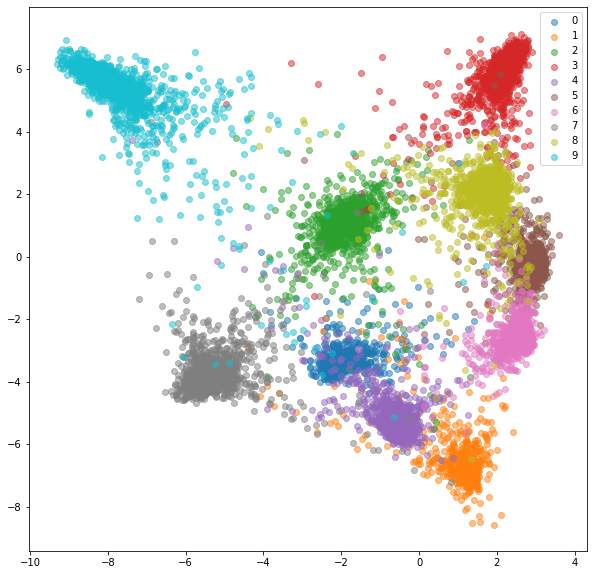

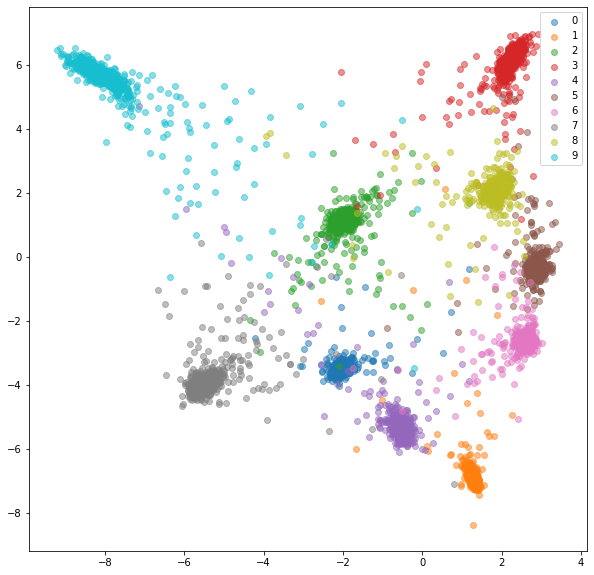

In [14]:
# train_dataset=siamese_MT_train_dataset
# test_dataset=siamese_MT_test_dataset

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)


train_embeddings_cl, train_labels_cl = extract_embeddings(train_loader, model_mt)
plot_embeddings(train_embeddings_cl, train_labels_cl)
val_embeddings_cl, val_labels_cl = extract_embeddings(test_loader, model_mt)
plot_embeddings(val_embeddings_cl, val_labels_cl)